#### GDAA 2010 - Data Mining Modelling
Project #2 - Applied Deep Learning in Python Using PyTorch

Submitted By: Tiana Gallo

Submitted To: Dr. Steven Edwards

Due Date: April 17, 2024

For this project I will be using industry standard Deep Learning workflows to generate class label predictions on a set of images. I will leverage the PyTorch framework to build my models. The first few code chunks are dedicated to setting up my GPU and assigning it to an object called "device".

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import torch
torch.cuda.empty_cache()

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4070 Laptop GPU'

In [6]:
torch.cuda.get_device_capability(0)

(8, 9)

In [7]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

The dataset I downloaded was from Kaggle and is an image classification dataset for butterflies. The dataset features 75 different classes of butterflies. The dataset contains about 1000+ labelled images inluding the validation images. Each image belongs to only one butterfly category. The label of each image are saved in "Training_set.csv". The "Testing_set.csv" contains names of images in "test" folder which is needed to predict the label.

First I created subfolders for the training dataset using the labels from the csv file. The labels will correspond to the subfolder names. 

In [ ]:
import os
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset

# Read the training CSV file
train_csv = r"C:\GDAA2000\Machine Learning Basics\data\butterfly_data\Training_set.csv"
df = pd.read_csv(train_csv)

# Define the root directory containing the training images
train_dir = r"C:\GDAA2000\Machine Learning Basics\data\butterfly_data\train"

labels = df['label'].unique()
for label in labels:
        label_dir = os.path.join(train_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

    # Move images to their respective label folders
for index, row in df.iterrows():
        image_filename = row['filename']
        label_folder = row['label']  # Assuming the column is correctly named 'label'
        src_path = os.path.join(train_dir, image_filename)
        dest_path = os.path.join(train_dir, str(label_folder), image_filename)
        os.replace(src_path, dest_path)

I created subfolders with the same process for the testing data as well.

In [ ]:

import shutil

# Read the training CSV file
train_csv = r"C:\GDAA2000\Machine Learning Basics\data\butterfly_data\Training_set.csv"
df_train = pd.read_csv(train_csv)

# Check if 'label' column exists in the training CSV file
if 'label' not in df_train.columns:
    print("Error: 'label' column not found in the training CSV file.")
    # You might need to inspect the CSV file and adjust the column name accordingly.
else:
    # Define the root directory containing the testing images
    test_dir = r"C:\GDAA2000\Machine Learning Basics\data\butterfly_data\test"

    # Create subfolders in the test directory based on the unique labels from the training CSV file
    labels_train = df_train['label'].unique()
    for label_train in labels_train:
        label_train_dir = os.path.join(test_dir, str(label_train))
        os.makedirs(label_train_dir, exist_ok=True)

    # Move images from the test directory to their respective label folders in the test directory
    for filename in os.listdir(test_dir):
        src_path = os.path.join(test_dir, filename)
        # Check if the filename exists in the training CSV file
        if filename in df_train['filename'].values:
            # Get the corresponding label from the training CSV file
            label_test = df_train[df_train['filename'] == filename]['label'].iloc[0]
            dest_path = os.path.join(test_dir, str(label_test), filename)
            shutil.move(src_path, dest_path)
        else:
            print(f"Warning: {filename} not found in training CSV file. Skipping...")

Now I have sucessfully created subfolders in both the "training" and "test" folders that are labelled based on species. I created variables to hold the paths to the directories containing the training and testing images of butterflies, respectively. The "transform" variables defines a sequence of transformations to be applied to the input images. The input images were resized to a square of size 250x250 pixels. Then the input image was converted to a PyTorch tensor which is required for processing by neural networks. "trainset" and "testset" are variables that created datasets using the "ImageFolder" class provided by torchvision. It automatically assigns class labels based on the folder structure and applies the specified transformations to each image. The batch size was set to 8, meaning that the model will process 8 images at a time during training. 

In [8]:
import torchvision
import torchvision.transforms as transforms

train_dir = r"C:\GDAA2000\Machine Learning Basics\data\butterfly_data\train"
test_dir = r"C:\GDAA2000\Machine Learning Basics\data\butterfly_data\test"

transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(), 
])

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Accessing class labels
classes = trainset.classes

batch_size = 8

Next, I verify what the shape of an individual tensor looks like:

In [9]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([3, 250, 250]), 0)

This means that my PyTorch tensors contain 3 channels, because they are RGB images, and that they are 250 by 250. The final zero just indicates that this first example has a class label of zero. Below, I confirm the labels and the correpsonding index values, which lets me know that things are stored correctly.

In [10]:
print(trainset.class_to_idx)

{'ADONIS': 0, 'AFRICAN GIANT SWALLOWTAIL': 1, 'AMERICAN SNOOT': 2, 'AN 88': 3, 'APPOLLO': 4, 'ATALA': 5, 'BANDED ORANGE HELICONIAN': 6, 'BANDED PEACOCK': 7, 'BECKERS WHITE': 8, 'BLACK HAIRSTREAK': 9, 'BLUE MORPHO': 10, 'BLUE SPOTTED CROW': 11, 'BROWN SIPROETA': 12, 'CABBAGE WHITE': 13, 'CAIRNS BIRDWING': 14, 'CHECQUERED SKIPPER': 15, 'CHESTNUT': 16, 'CLEOPATRA': 17, 'CLODIUS PARNASSIAN': 18, 'CLOUDED SULPHUR': 19, 'COMMON BANDED AWL': 20, 'COMMON WOOD-NYMPH': 21, 'COPPER TAIL': 22, 'CRECENT': 23, 'CRIMSON PATCH': 24, 'DANAID EGGFLY': 25, 'EASTERN COMA': 26, 'EASTERN DAPPLE WHITE': 27, 'EASTERN PINE ELFIN': 28, 'ELBOWED PIERROT': 29, 'GOLD BANDED': 30, 'GREAT EGGFLY': 31, 'GREAT JAY': 32, 'GREEN CELLED CATTLEHEART': 33, 'GREY HAIRSTREAK': 34, 'INDRA SWALLOW': 35, 'IPHICLUS SISTER': 36, 'JULIA': 37, 'LARGE MARBLE': 38, 'MALACHITE': 39, 'MANGROVE SKIPPER': 40, 'MESTRA': 41, 'METALMARK': 42, 'MILBERTS TORTOISESHELL': 43, 'MONARCH': 44, 'MOURNING CLOAK': 45, 'ORANGE OAKLEAF': 46, 'ORANGE TI

I can visualize a specific image from the training dataset along with its label using Matplotlib. It's a helpful way to inspect individual images and their coresponding labels during the data preprocessing and exploration phase. 

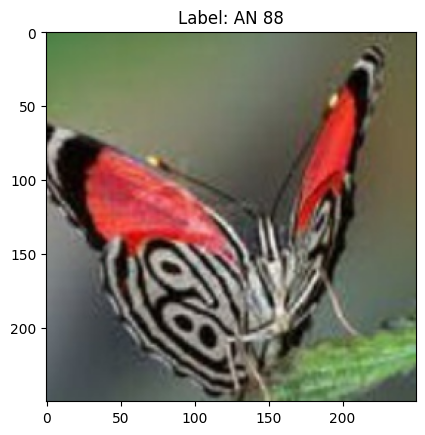

In [11]:
import matplotlib.pyplot as plt

index = 300  # This selects the image from the training data by index number

image, label = trainset[index] # Get the image and its label

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {classes[label]}")
plt.show()

#### Prep Data for Training

Data preparation primarily involves splitting the training data into training/validation splits, just as in traditional machine learning. This is useful for gauging model performance during training, similar to cross validation. 

Below I confirm the size of my training and test datasets:

In [12]:
len(trainset), len(testset)

(6499, 2786)

Now, I use PyTorch to create subsets of my training data, dividing it into training and validation datasets. I will use the test dataset later to verify model performance.

In [13]:
trainset, valset = torch.utils.data.random_split(trainset, [5499, 1000])
len(trainset), len(valset), len(testset)

(5499, 1000, 2786)

It's also helpful to know how many batches our data will be divided into during training, and we can quickly check that using the following code:


In [14]:
print(f'Number of batches in the training set: {int(5499 / batch_size)}')
print(f'Number of batches in the validation set: {int(1000 / batch_size)}')

Number of batches in the training set: 687
Number of batches in the validation set: 125


And last, we can verify that our training data is now considered a subset of the overall dataset, which is what happens when we use PyTorch to split our training data into train/validation sets. 

In [15]:
type(trainset)

torch.utils.data.dataset.Subset

#### Model Preparation

Next, I set up data loaders for the training, validation, and test datasets in PyTorch. Data loaders are used to efficiently load data in batches during the training, validation, and testing phases of model development. 

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#### Define CNN Architecture

A Convolutional Neural Network (CNN) is a type of deep neural network particularly wells-suited for analyzing visual data such as images. CNNs are designed to automatically and adaptively learn spatial hierarchies of features from the input data. Convolutional layers are the core building blocks of CNNs. They apply learnable filters, or kernels, to input data, extracting features such as edges, textures, and patterns. The convolution operation involves sliding the filter over the input data and computing element-wise multiplications followed by summation to produce features maps. Pooling layers are used to downsample the feature maps produced by convolutional layers. Here I used max-pooling layers applied after each convolutional layer to downsample the feature maps while retaining important information. Then the size of the flattened feature map was calculated after passing through all concolutional and pooling layers. The flattened output is passed through fully connected layers with ReLU activation functions and dropout layers. The output from the last fully connected layer is passed through the output layer which produces the final logits for each class. 

In [17]:

import torch.nn as nn
import torch.nn.functional as F

num_classes = 75

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Calculate the size of the flattened features after all convolutional and pooling layers
        self._flattened_features = self._get_conv_output_size()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=self._flattened_features, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.drop2 = nn.Dropout(p=0.3)
        self.out = nn.Linear(in_features=512, out_features=75)

    def _get_conv_output_size(self):
        # Create a dummy input to pass through the convolutional layers only
        dummy_input = torch.zeros(1, 3, 250, 250)  # Use the provided input dimensions
        dummy_input = self.conv1(dummy_input)
        dummy_input = self.pool1(dummy_input)
        dummy_input = self.conv2(dummy_input)
        dummy_input = self.pool2(dummy_input)
        dummy_input = self.conv3(dummy_input)
        dummy_input = self.pool3(dummy_input)
        return int(torch.flatten(dummy_input, 1).size(1))

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        # Output layer
        x = self.out(x)

        return x

#### Push Model to Device and and Verify Parameters

Since my model is to be run on a GPU, I have to "push" it to that device.  

Further, I will want to check the shape of my input features and output features, as expected by my model architecture. For this case, I want my output tensors to be in the defined batch size, and have 75 possible class labels. 

In [18]:

net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=230400, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=75, bias=True)
)

Now we iterate over the training data loader and print out the shapes of the input data and the output of the neural network for the first batch of data. 

In [19]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

input shape: torch.Size([8, 3, 250, 250])
after network shape: torch.Size([8, 75])


The batch size is 8, which means there are 8 samples in this batch. The number of channels in the image is 3, indicating that the images are RGB. The height and width of the input images are 250. After the network shape, the output tensor has a shape of [8, 75], meaning that the batch size also consists of 8 samples for the output and there are 75 classes in the classification. 

Now, we iterate over all the parameters of the neural network model, flatten each parameter tensor to count the number of elements, and accumulate the count to calculate the total number of parameters in the model. 

In [20]:
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 237,228,235


#### Select Loss Function and Optimization Technique

Next, I set up the loss function "CrossEntropyLoss" and optimizer "Adam" for training the neural network model. The optimizer will update the model parameters based on the gradients computed by backpropogation to minimize the loss. The learning rate controls the step size of parameter updates during optimization. A learning rate of 0.0001 is specified here, but I did experiment by changing it to different values. I found the current value to generate the most accurate predictions. 

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) 

#### Define and Run the Training Loop

**Setup Training Epoch**

In this step, I defined a function "train_one_epoch()" that trains a neural network model for one epoch using a given training data loader, loss functions, and optimizer. The for loop will iterate over the batches of data in the training data loader. The if statement checks if 50 batches have been processed and prints the average loss and accuracy acros these 50 batches. The running loss and accuracy for the next set of batches will be reset. 

In [22]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs) 
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 50 == 49:  
      avg_loss_across_batches = running_loss / 50
      avg_acc_across_batches = (running_accuracy / 50) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

    
  print()

**Setup Validation Epoch**

Similarly to the last code chunk, this function performs one validation epoch by iterating over the batches of data, computing the loss and accuracy for each batch, and then prints the average loss and accuracy for the entire validation dataset. 

In [23]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs) 
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

I wanted to better visualize the distribution classes for both the training dataset and the validation dataset. The output shows two barplot side by side, displaying class distribution.

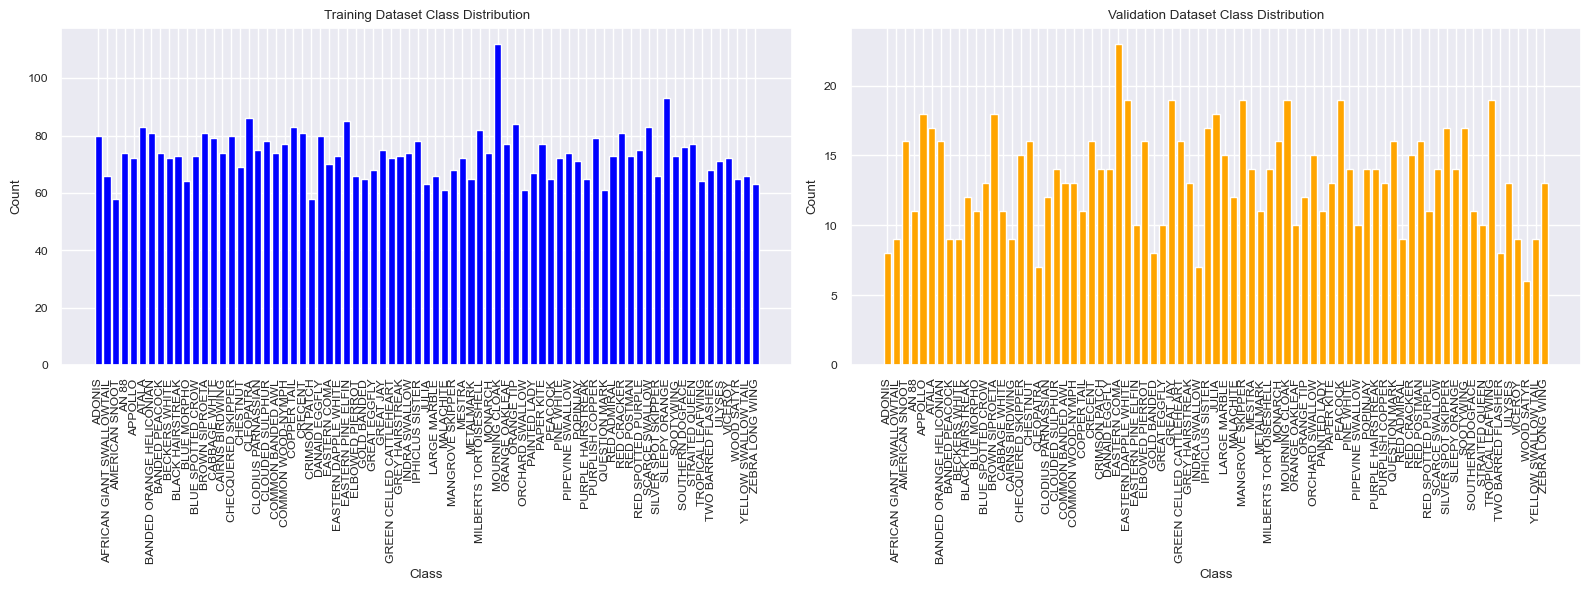

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute class distributions
def compute_class_distribution(dataset):
    class_counts = np.zeros(len(dataset.dataset.classes))  # Access classes from the original dataset
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

# Compute class distributions for training and validation datasets
train_class_distribution = compute_class_distribution(trainset)
val_class_distribution = compute_class_distribution(valset)

# Plotting
plt.figure(figsize=(16, 6))

# Training dataset bar plot
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(train_class_distribution)), train_class_distribution, color='blue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Dataset Class Distribution')
plt.xticks(np.arange(len(train_class_distribution)), trainset.dataset.classes, rotation=90)  # Access classes from the original dataset

# Validation dataset bar plot
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(val_class_distribution)), val_class_distribution, color='orange')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Validation Dataset Class Distribution')
plt.xticks(np.arange(len(val_class_distribution)), valset.dataset.classes, rotation=90)  # Access classes from the original dataset

plt.tight_layout()
plt.show()

**Train the Model**

With our training and validation loops defined, we can now, at long last, train our model! The next code chunk runs a training loop over 10 epochs, where each epoch consists of training the model of the training dataset and validating it on the validation dataset. After all the epochs are completed, the training process is completed. This iterative process allows the model to gradually learn from the training data and improve its performance over time. I ran the code with different number of epochs (1, 5, and 10), and found that running it with 10 epochs produces the best accuracy. This is expected as neural network models often require multiple passes through the training data to converge to an optimal solution. By training more epochs, the model has more opportunities to adjust its parameters and refine its internal representations, leading to improved performance. 

In [24]:

num_epochs = 10

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    validate_one_epoch()
    
print('Finished Training')

Epoch: 1

Batch 50, Loss: 4.331, Accuracy: 1.2%
Batch 100, Loss: 4.294, Accuracy: 2.5%
Batch 150, Loss: 4.265, Accuracy: 1.8%
Batch 200, Loss: 4.253, Accuracy: 2.5%
Batch 250, Loss: 4.162, Accuracy: 6.2%
Batch 300, Loss: 3.984, Accuracy: 5.0%
Batch 350, Loss: 4.031, Accuracy: 4.8%
Batch 400, Loss: 3.861, Accuracy: 7.0%
Batch 450, Loss: 3.715, Accuracy: 9.5%
Batch 500, Loss: 3.635, Accuracy: 9.8%
Batch 550, Loss: 3.365, Accuracy: 15.0%
Batch 600, Loss: 3.279, Accuracy: 17.0%
Batch 650, Loss: 3.229, Accuracy: 17.0%

Val Loss: 2.938, Val Accuracy: 23.9%
***************************************************

Epoch: 2

Batch 50, Loss: 3.059, Accuracy: 20.0%
Batch 100, Loss: 2.880, Accuracy: 26.8%
Batch 150, Loss: 2.888, Accuracy: 22.5%
Batch 200, Loss: 2.827, Accuracy: 27.3%
Batch 250, Loss: 2.626, Accuracy: 30.8%
Batch 300, Loss: 2.502, Accuracy: 31.5%
Batch 350, Loss: 2.617, Accuracy: 29.8%
Batch 400, Loss: 2.577, Accuracy: 29.8%
Batch 450, Loss: 2.436, Accuracy: 32.2%
Batch 500, Loss: 2.47

#### Evaluate the Model

Now that the training is completed, the model can be evaluated. The for loop iterates through the test set which contains batches of test data and labels. After iterating through all batches, the accuracy of the model's predictions is calculated. A classification report and confusion matrix are generated. 

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Get predicted labels from the model
predicted_labels = []
true_labels = []

# Iterate through test set and collect predictions
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=classes)


# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

Accuracy: 0.012921751615218953


In [26]:
print("Classification Report:\n", class_report)

Classification Report:
                            precision    recall  f1-score   support

                   ADONIS       0.00      0.00      0.00        43
AFRICAN GIANT SWALLOWTAIL       0.00      0.00      0.00        36
           AMERICAN SNOOT       0.00      0.00      0.00        38
                    AN 88       0.03      0.02      0.03        43
                  APPOLLO       0.02      0.03      0.02        39
                    ATALA       0.00      0.00      0.00        42
 BANDED ORANGE HELICONIAN       0.00      0.00      0.00        40
           BANDED PEACOCK       0.00      0.00      0.00        39
            BECKERS WHITE       0.06      0.03      0.04        32
         BLACK HAIRSTREAK       0.00      0.00      0.00        43
              BLUE MORPHO       0.00      0.00      0.00        31
        BLUE SPOTTED CROW       0.00      0.00      0.00        31
           BROWN SIPROETA       0.00      0.00      0.00        45
            CABBAGE WHITE       0.01 

In [27]:
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[0 1 0 ... 0 1 0]
 [2 0 0 ... 1 0 1]
 [3 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 [0 1 0 ... 0 0 0]]


Lastly, I visualized my confusion matrix with a bit more formatting:

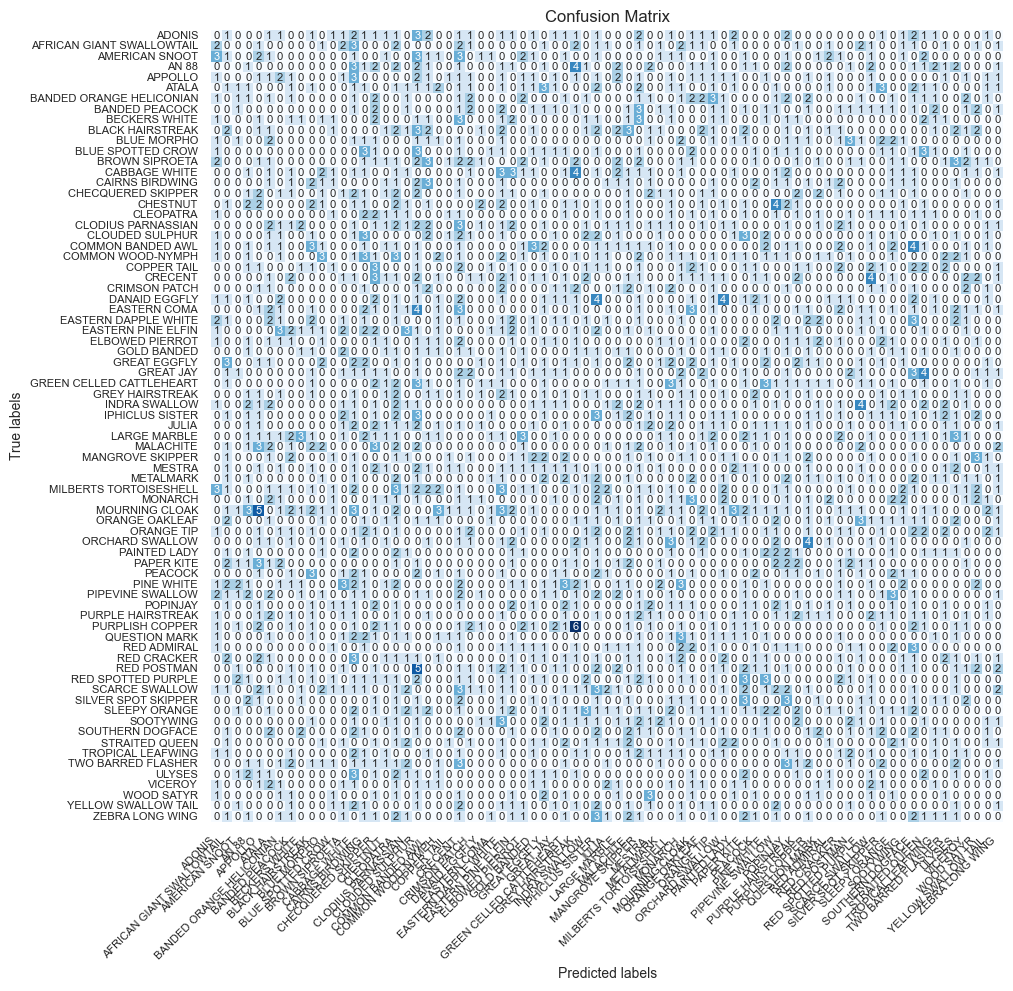

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase the figure size
plt.figure(figsize=(12, 10))

# Plot confusion matrix
sns.set(font_scale=0.8)  # Decrease font scale for better readability
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", 
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 8}, cbar=False)

# Adjust tick label rotation and size
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Add labels and title
plt.xlabel("Predicted labels", fontsize=10)
plt.ylabel("True labels", fontsize=10)
plt.title("Confusion Matrix", fontsize=12)

# Adjust the aspect ratio of the heatmap to prevent overlap
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#### Conclusion

Based on the classification report, the model accuracy is not good. The precision, recall, and F1-score values for most classes are very low, ranging from 0 to 0.07. The overally accuracy of the model is only 0.01, indicating that the model is making correct predictions for only 1% of instances in the dataset. Clearly, the model seems to lack the ability to distinguish between different classes effectively. I believe applying some data augmentation could improve image classification accuracy as it can introduce variations in the training images, such as rotations, flips, translations, and changes in brightness or contrast. There does also seem to be some class imbalance as seen in the disrtibution of the validation dataset, where some classes have significantly fewer samples than others. Data augmentation could help address this issue by generating synthetic samples for underrepresented classes and improving the model's ability to learn from all classes equally. 

Increasing the number of epochs could also improve the accuracy as the model would have more oppertunities to adjust its parameters and refine internal representations. Some complex patterns in the data may require more training iterations to be learned effectively, so increasing the number of epochs would allow the model to capture these intricate patterns and make better predictions.